In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import scipy.integrate as spi
import h5py
import os
import seaborn as sns

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import stats
from scipy.optimize import curve_fit

In [12]:
# file_path = '/fred/oz009/cpower/TheThreeHundred/NewMDCLUSTER_001/GIZMO_7k-NewMDCLUSTER_001.snap_128.z0.000.AHF_halos'
# with open(file_path, 'r') as file:
#     print(file.readline())  

# DM_density = np.loadtxt('./data/density_profiles_GIZMO_7k_DM.txt')
DM_density48 = np.loadtxt('/fred/oz009/kwalker/data/TheThreeHundred/ming/density_profiles_DM_100r48a_GadgetX.txt')
Gas_density = np.loadtxt('./data/density_profiles_GIZMO_7k_gas.txt')
Stars_density = np.loadtxt('./data/density_profiles_GIZMO_7k_stars.txt')
Gas_sph_density = np.loadtxt('./data/density_sph_profiles_GIZMO_7k_gas.txt')
# Gas_entropy = np.loadtxt('./data/entropy_profiles_GIZMO_7k_gas.txt')
Gas_entropy48 = np.loadtxt('/fred/oz009/kwalker/data/TheThreeHundred/ming/entropy_profiles_100r48a_GadgetX.txt')
Gas_internalenergy = np.loadtxt('./data/internal_energy_profiles_GIZMO_7k_gas.txt')
M200_R200 = np.loadtxt('./data/cluster_M200_R200_GIZMO_7k_snap128.txt')
Properties = np.loadtxt('./data/cluster_properties_GIZMO_7k_snap128.txt')
History = np.loadtxt('./data/M200_histories_GIZMO.txt')

print(DM_density48.shape,Gas_density.shape,Stars_density.shape,Gas_sph_density.shape,Gas_entropy48.shape,Gas_internalenergy.shape
     ,M200_R200.shape, Properties.shape)

print(DM_density48)
DM_density_reshaped = DM_density48.reshape(324, 48, 100)
DM_density = np.median(DM_density_reshaped, axis=1)

Gas_entropy_reshaped = Gas_entropy48.reshape(324, 48, 100)
Gas_entropy = np.nanmedian(Gas_entropy_reshaped, axis=1)

(15552, 100) (324, 100) (324, 100) (324, 100) (15552, 100) (324, 100) (324, 2) (324, 86)
[[9.46402178e-07 1.42046308e-06 1.37617440e-06 ... 2.14736153e-08
  4.30019819e-08 1.88097433e-08]
 [1.07948998e-06 9.10199646e-07 6.68795034e-07 ... 7.65093181e-10
  6.97672273e-10 9.90764780e-10]
 [5.78192580e-06 4.09589841e-06 3.40828239e-06 ... 3.57043485e-09
  2.79068909e-09 3.04623201e-09]
 ...
 [4.09147418e-06 3.24621169e-06 3.13365342e-06 ... 3.29996193e-09
  3.73235460e-09 4.76320874e-09]
 [6.83947922e-06 7.74534718e-06 7.22333671e-06 ... 7.01417441e-08
  2.72396406e-08 2.25947081e-08]
 [9.58748426e-06 8.48571125e-06 6.53287070e-06 ... 2.17657064e-09
  2.48823640e-09 2.32053759e-09]]


1.8391898859143172


(0.5, 5)

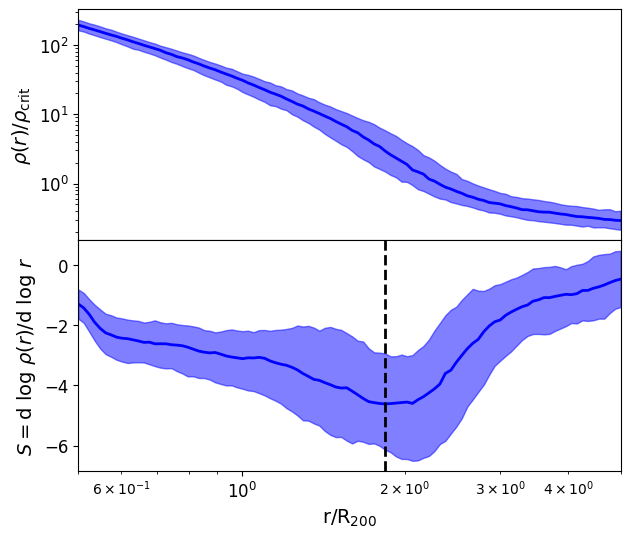

In [13]:
# DM density profile
Rsp=[]
rhonorm=2.7753662724817174e-08#*0.6777**2
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']
start = 0.5
end = 5
log_bins = np.logspace(np.log10(start), np.log10(end), 100)

fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in range(DM_density.shape[0]):
# for i in range(10):
    # ax1.plot(log_bins, DM_density[i]/rhonorm, color='blue',linewidth=0.5, alpha=0.2)
    smoothed_density = gaussian_filter1d(DM_density[i], sigma=2)
    # smoothed_density = savgol_filter(DM_density[i], window_length=15, polyorder=3, deriv=0, delta=0.1)
    log_D = np.log(smoothed_density)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    # ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.2) # colors[i % len(colors)]
    
    restricted_indices = np.where((log_bins >= 0.55) & (log_bins <= 4.5))[0]
    rr = log_bins[restricted_indices]
    smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
    
    r_splash_index = np.argmin(smoothed_d_log_D_restricted)
    r_splash = rr[r_splash_index]
    
    interp_func = interp1d(log_bins, smoothed_d_log_D, kind='cubic')
    log_bins_dense = np.linspace(r_splash-0.2, r_splash+0.2, 500)
    smoothed_d_log_D_dense = interp_func(log_bins_dense)
    max_index = np.argmin(smoothed_d_log_D_dense)
    r_splash = log_bins_dense[max_index]

    Rsp.append(r_splash)
    
median_DM_density = np.median(DM_density, axis=0)
percentile16_DM_density = np.percentile(DM_density, 10, axis=0)
percentile84_DM_density = np.percentile(DM_density, 90, axis=0)

ax1.plot(log_bins, median_DM_density / rhonorm, color='b', linewidth=2.0, alpha=1)
ax1.fill_between(log_bins, percentile16_DM_density / rhonorm, percentile84_DM_density / rhonorm, color='b', alpha=0.5)

d_log_D_all = []
for density in DM_density:
    # smoothed_density = savgol_filter(density, window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_density = gaussian_filter1d(density, sigma=2)
    log_D = np.log(smoothed_density)
    d_log_D = np.gradient(log_D, log_r)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    d_log_D_all.append(smoothed_d_log_D)

d_log_D_all = np.array(d_log_D_all)
median_d_log_D = np.median(d_log_D_all, axis=0)
percentile16_d_log_D = np.percentile(d_log_D_all, 10, axis=0)
percentile84_d_log_D = np.percentile(d_log_D_all, 90, axis=0)

ax2.plot(log_bins, median_d_log_D, color='b', linestyle='-', linewidth=2.0)
ax2.fill_between(log_bins, percentile16_d_log_D, percentile84_d_log_D, color='b', alpha=0.5)

restricted_indices = np.where((log_bins >= 0.55) & (log_bins <= 4.5))[0]
rr = log_bins[restricted_indices]
smoothed_d_log_D_restricted = median_d_log_D[restricted_indices]
r_splash_index = np.argmin(smoothed_d_log_D_restricted)
r_splash1 = rr[r_splash_index]
ax2.axvline(x=r_splash1, color='black', linestyle='--', linewidth=2.0)
print(r_splash1)

ax1.set_ylabel(r'$\rho(r)/\rho_{\rm crit}$', fontsize=14) #{\rm Log}_{10} 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.5,5)
ax1.get_xaxis().set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel(r'${\rm r/R}_{200}$', fontsize=14)
ax2.set_ylabel(r'$S = {\rm d~log}~\rho(r) / {\rm d~log}~r$', fontsize=14)
# ax2.set_ylabel(r'$S$')
ax2.set_xlim(0.5,5)
# ax2.set_ylim(-6.8,3)
# plt.savefig("./figures/DM_splashback_radius_GIZMO_7k.png")

[2.90725583e+10 2.54095735e+10 2.42338734e+10 2.41377136e+10
 2.44231990e+10 2.43705992e+10 2.17157724e+10 2.54399047e+10
 2.15931493e+10 2.04324524e+10]
2.607004143999843
4.248767179543223


(0.5, 5)

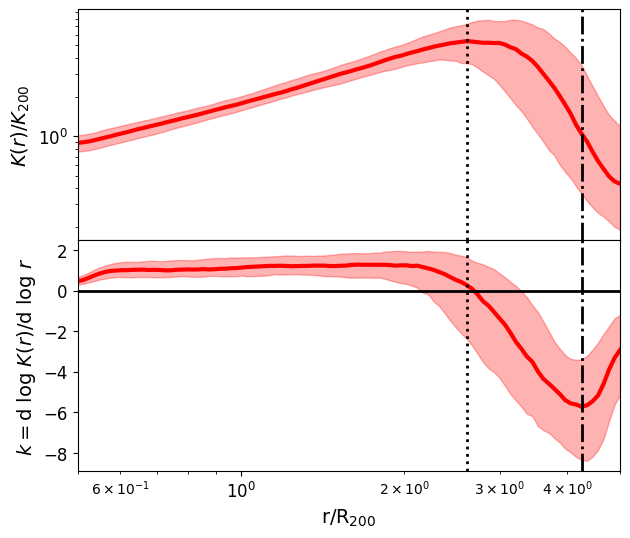

In [14]:
M200 = M200_R200[:,0]
R200 = M200_R200[:,1]
K200 = 0.5 / (200*rhonorm*0.156)**(2/3) * 4.3e-6 * M200 / R200
print(K200[:10])

# Gas entropy profile
Rsh=[]
Rsh2=[]
Gas_K=[]
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in range(Gas_entropy.shape[0]):
# for i in range(10):
    # ax1.plot(log_bins, Gas_entropy[i]/K200[i], color='blue',linewidth=0.5, alpha=0.3)
    # smoothed_entropy = savgol_filter(Gas_entropy[i]/K200[i], window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_entropy = gaussian_filter1d(Gas_entropy[i], sigma=2)
    log_D = np.log(smoothed_entropy)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    # ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.3) # colors[i % len(colors)]

    r_range_mask = (log_bins >= 0.55) & (log_bins <= 4.5)
    rgav_1_in_range = log_bins[r_range_mask]
    umed_av_in_range = smoothed_entropy[r_range_mask]
    
    if len(umed_av_in_range) > 0:
        max_entropy_index = np.argmax(umed_av_in_range)
        r_shock = rgav_1_in_range[max_entropy_index]

        interp_func = interp1d(log_bins, smoothed_entropy, kind='cubic')
        log_bins_dense = np.linspace(r_shock-0.2, r_shock+0.2, 500)
        smoothed_entropy_dense = interp_func(log_bins_dense)
        max_index = np.argmax(smoothed_entropy_dense)
        r_shock = log_bins_dense[max_index]

    Rsh.append(r_shock)

    restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 4.9))[0]
    rr = log_bins[restricted_indices]
    smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
    r_shock2_index = np.argmin(smoothed_d_log_D_restricted)
    r_shock2 = rr[r_shock2_index]
    
    interp_func = interp1d(log_bins, smoothed_d_log_D, kind='cubic')
    log_bins_dense = np.linspace(r_shock2-0.2, r_shock2+0.1, 500)
    smoothed_d_log_D_dense = interp_func(log_bins_dense)
    max_index = np.argmin(smoothed_d_log_D_dense)
    r_shock2 = log_bins_dense[max_index]

    # ax1.axvline(x=r_shock2, color='black', linestyle='--', linewidth=0.2)
    # ax2.axvline(x=r_shock2, color='black', linestyle='--', linewidth=0.2)

    Rsh2.append(r_shock2)
    Gas_K.append(smoothed_entropy/K200[i])

median_Gas_entropy = np.median(Gas_K, axis=0)
percentile16_Gas_entropy = np.percentile(Gas_K, 10, axis=0)
percentile84_Gas_entropy = np.percentile(Gas_K, 90, axis=0)
ax1.plot(log_bins, median_Gas_entropy, color='r', linewidth=3.0, alpha=1)
ax1.fill_between(log_bins, percentile16_Gas_entropy, percentile84_Gas_entropy, color='r', alpha=0.3)

d_log_D_all = []
for entropy in Gas_K:
    # smoothed_entropy = savgol_filter(entropy, window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_entropy = gaussian_filter1d(entropy, sigma=2)
    log_D = np.log(smoothed_entropy)
    d_log_D = np.gradient(log_D, log_r)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    d_log_D_all.append(smoothed_d_log_D)

d_log_D_all = np.array(d_log_D_all)
median_d_log_D = np.median(d_log_D_all, axis=0)
percentile16_d_log_D = np.percentile(d_log_D_all, 10, axis=0)
percentile84_d_log_D = np.percentile(d_log_D_all, 90, axis=0)
ax2.plot(log_bins, median_d_log_D, color='r', linestyle='-', linewidth=3.0)
ax2.fill_between(log_bins, percentile16_d_log_D, percentile84_d_log_D, color='r', alpha=0.3)

r_range_mask = (log_bins >= 1) & (log_bins <= 5)
rgav_1_in_range = log_bins[r_range_mask]
umed_av_in_range = median_Gas_entropy[r_range_mask]
if len(umed_av_in_range) > 0:
    max_entropy_index = np.argmax(umed_av_in_range)
    r_shock1 = rgav_1_in_range[max_entropy_index]
ax1.axvline(x=r_shock1, color='black', linestyle=':', linewidth=2)
ax2.axvline(x=r_shock1, color='black', linestyle=':', linewidth=2)
print(r_shock1)

restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 5))[0]
rr = log_bins[restricted_indices]
smoothed_d_log_D_restricted = median_d_log_D[restricted_indices]
r_shock_index = np.argmin(smoothed_d_log_D_restricted)
r_shock2 = rr[r_shock_index]
ax1.axvline(x=r_shock2, color='black', linestyle='-.', linewidth=2.0)
ax2.axvline(x=r_shock2, color='black', linestyle='-.', linewidth=2.0)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=2.0)
print(r_shock2)

ax1.set_ylabel(r'$K(r)/K_{200}$', fontsize=14) #/K_{200}
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.5,5)
ax1.get_xaxis().set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel(r'${\rm r/R}_{200}$', fontsize=14)
ax2.set_ylabel(r'$k = {\rm d~log}~K(r) / {\rm d~log}~r$', fontsize=14)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlim(0.5,5)
# ax2.set_ylim(-6,3.5)
# plt.savefig("./figures/GAS_shock_radius_GIZMO_7k.png")

Fit: Rsh2 = -0.72 * M200 + 14.80
Fit: Rsh = -0.74 * M200 + 13.85
Fit: Rsp = -0.53 * M200 + 9.78


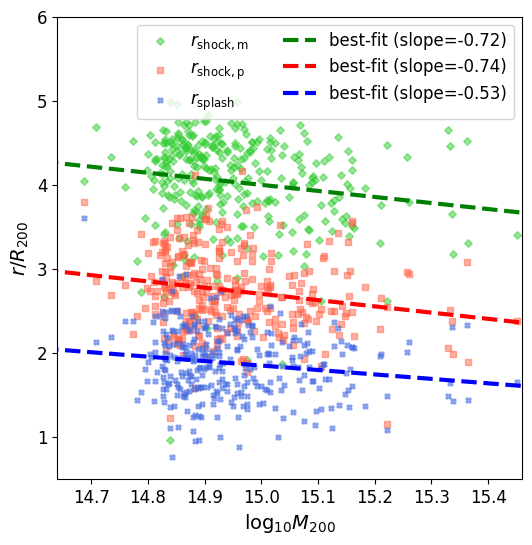

In [10]:
M200 = M200_R200[:,0]
fig = plt.figure(figsize=(6, 6))
ax1=fig.add_subplot(1,1,1)
ax1.scatter(np.log10(M200), np.array(Rsh2), marker='D', color='limegreen',s=15, alpha=0.5, label=r'$r_{\rm shock,m}$')
ax1.scatter(np.log10(M200), np.array(Rsh), marker=',', color='tomato',s=15, alpha=0.5, label=r'$r_{\rm shock,p}$')
ax1.scatter(np.log10(M200), np.array(Rsp), marker='X', color='royalblue',s=15, alpha=0.5, label=r'$r_{\rm splash}$')

popt, pcov = curve_fit(linear_model, np.log10(M200), Rsh2)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）

# M200_range = np.linspace(min(np.log10(M200)), max(np.log10(M200)), 100)
M200_range = np.linspace(14, 16, 100)
Rsh2_fit = linear_model(M200_range, k_fit, b_fit)
Rsh2_fit_upper = linear_model(M200_range, k_fit + sigma[0], b_fit + sigma[1])
Rsh2_fit_lower = linear_model(M200_range, k_fit - sigma[0], b_fit - sigma[1])

# plt.plot(M200_range, Rsh_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='red', linestyle='--', linewidth=2)
plt.plot(M200_range, Rsh2_fit, color='g', linestyle='--', linewidth=3, label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsh2 = {k_fit:.2f} * M200 + {b_fit:.2f}')

popt, pcov = curve_fit(linear_model, np.log10(M200), Rsh)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）
# M200_range = np.linspace(min(np.log10(M200)), max(np.log10(M200)), 100)
M200_range = np.linspace(14, 16, 100)
Rsh_fit = linear_model(M200_range, k_fit, b_fit)
Rsh_fit_upper = linear_model(M200_range, k_fit + sigma[0], b_fit + sigma[1])
Rsh_fit_lower = linear_model(M200_range, k_fit - sigma[0], b_fit - sigma[1])

# plt.plot(M200_range, Rsh_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='red', linestyle='--', linewidth=2)
plt.plot(M200_range, Rsh_fit, color='red', linestyle='--', linewidth=3, label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsh = {k_fit:.2f} * M200 + {b_fit:.2f}')

# ax1.scatter(np.log10(M200), np.array(Rsp), color='royalblue',s=15, alpha=0.6, label=r'$r_{\rm splash}$')
popt, pcov = curve_fit(linear_model, np.log10(M200), Rsp)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）

# M200_range = np.linspace(min(np.log10(M200)), max(np.log10(M200)), 100)
M200_range = np.linspace(14, 16, 100)
Rsp_fit = linear_model(M200_range, k_fit, b_fit)
Rsp_fit_upper = linear_model(M200_range, k_fit + sigma[0], b_fit + sigma[1])
Rsp_fit_lower = linear_model(M200_range, k_fit - sigma[0], b_fit - sigma[1])

# plt.plot(M200_range, Rsp_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='b', linestyle='--', linewidth=2)
plt.plot(M200_range, Rsp_fit, color='b', linestyle='--', linewidth=3,label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsp = {k_fit:.2f} * M200 + {b_fit:.2f}')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel(r'$r/R_{200}$', fontsize=14)
plt.xlabel(r'log$_{10} M_{200}$', fontsize=14)
plt.xlim(14.64,15.46)
plt.ylim(0.5,6)
plt.legend(ncols=2, fontsize=12)
# plt.savefig("./figures/Mass_radius.png")

Fit: Rsh2 = -1.13 * acrretion + 4.62
Fit: Rsh = -1.10 * acrretion + 3.30
Fit: Rsp = -1.01 * acrretion + 2.40


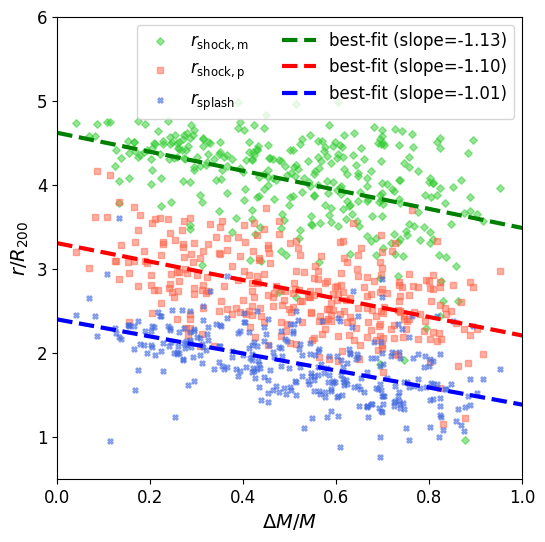

In [11]:
redshifts = History[:, 0]
masses = History[:, 1:]
interp_func = interp1d(redshifts, masses, axis=0, kind='linear', fill_value="extrapolate")
mass_z0 = interp_func(0)
mass_z05 = interp_func(0.5)
accretion_rate = (mass_z0 - mass_z05) / mass_z0

fig = plt.figure(figsize=(6, 6))
ax1=fig.add_subplot(1,1,1)
ax1.scatter(accretion_rate, np.array(Rsh2), marker='D', color='limegreen',s=15, alpha=0.5, label=r'$r_{\rm shock,m}$')
ax1.scatter(accretion_rate, np.array(Rsh), marker=',', color='tomato',s=15, alpha=0.5, label=r'$r_{\rm shock,p}$')
ax1.scatter(accretion_rate, np.array(Rsp), marker='X', color='royalblue',s=15, alpha=0.5, label=r'$r_{\rm splash}$')

# ax1.scatter(accretion_rate, np.array(Rsh2), color='limegreen',s=15, alpha=0.6, label=r'$r_{\rm shock}$')
popt, pcov = curve_fit(linear_model, accretion_rate, Rsh2)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）
# accretion_rate_range = np.linspace(min(accretion_rate), max(accretion_rate), 100)
accretion_rate_range = np.linspace(0, 2, 100)
Rsh2_fit = linear_model(accretion_rate_range, k_fit, b_fit)
Rsh2_fit_upper = linear_model(accretion_rate_range, k_fit + sigma[0], b_fit + sigma[1])
Rsh2_fit_lower = linear_model(accretion_rate_range, k_fit - sigma[0], b_fit - sigma[1])
# plt.plot(M200_range, Rsh_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='red', linestyle='--', linewidth=2)
plt.plot(accretion_rate_range, Rsh2_fit, color='g', linestyle='--', linewidth=3,label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsh2 = {k_fit:.2f} * acrretion + {b_fit:.2f}')


popt, pcov = curve_fit(linear_model, accretion_rate, Rsh)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）
# accretion_rate_range = np.linspace(min(accretion_rate), max(accretion_rate), 100)
accretion_rate_range = np.linspace(0, 2, 100)
Rsh_fit = linear_model(accretion_rate_range, k_fit, b_fit)
Rsh_fit_upper = linear_model(accretion_rate_range, k_fit + sigma[0], b_fit + sigma[1])
Rsh_fit_lower = linear_model(accretion_rate_range, k_fit - sigma[0], b_fit - sigma[1])
# plt.plot(M200_range, Rsh_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='red', linestyle='--', linewidth=2)
plt.plot(accretion_rate_range, Rsh_fit, color='r', linestyle='--', linewidth=3,label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsh = {k_fit:.2f} * acrretion + {b_fit:.2f}')


# ax1.scatter(accretion_rate, np.array(Rsp), color='royalblue',s=15, alpha=0.6, label=r'$r_{\rm splash}$')
popt, pcov = curve_fit(linear_model, accretion_rate, Rsp)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）
# accretion_rate_range = np.linspace(min(accretion_rate), max(accretion_rate), 100)
accretion_rate_range = np.linspace(0, 2, 100)
Rsp_fit = linear_model(accretion_rate_range, k_fit, b_fit)
Rsp_fit_upper = linear_model(accretion_rate_range, k_fit + sigma[0], b_fit + sigma[1])
Rsp_fit_lower = linear_model(accretion_rate_range, k_fit - sigma[0], b_fit - sigma[1])
# plt.plot(M200_range, Rsp_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='b', linestyle='--', linewidth=2)
plt.plot(accretion_rate_range, Rsp_fit, color='b', linestyle='--', linewidth=3,label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsp = {k_fit:.2f} * acrretion + {b_fit:.2f}')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel(r'$r/R_{200}$', fontsize=14)
plt.xlabel(r'$\Delta M / M$', fontsize=14)
plt.xlim(0,1)
plt.ylim(0.5,6)
plt.legend(ncols=2, fontsize=12)
# plt.savefig("./figures/Accretion_radius.png")

1.8391898859143172


(0.5, 5.0)

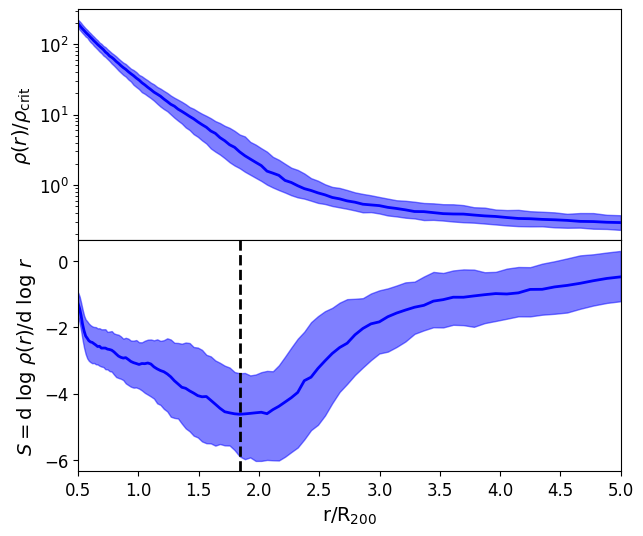

In [4]:
# DM density profile
Rsp=[]
rhonorm=2.7753662724817174e-08#*0.6777**2
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']
start = 0.5
end = 5
log_bins = np.logspace(np.log10(start), np.log10(end), 100)

fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in range(DM_density.shape[0]):
# for i in range(10):
    # ax1.plot(log_bins, DM_density[i]/rhonorm, color='blue',linewidth=0.5, alpha=0.2)
    smoothed_density = gaussian_filter1d(DM_density[i], sigma=2)
    # smoothed_density = savgol_filter(DM_density[i], window_length=15, polyorder=3, deriv=0, delta=0.1)
    log_D = np.log(smoothed_density)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    # ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.2) # colors[i % len(colors)]
    
    restricted_indices = np.where((log_bins >= 0.55) & (log_bins <= 4.5))[0]
    rr = log_bins[restricted_indices]
    smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
    
    r_splash_index = np.argmin(smoothed_d_log_D_restricted)
    r_splash = rr[r_splash_index]
    
    interp_func = interp1d(log_bins, smoothed_d_log_D, kind='cubic')
    log_bins_dense = np.linspace(r_splash-0.2, r_splash+0.2, 500)
    smoothed_d_log_D_dense = interp_func(log_bins_dense)
    max_index = np.argmin(smoothed_d_log_D_dense)
    r_splash = log_bins_dense[max_index]

    Rsp.append(r_splash)
    
median_DM_density = np.median(DM_density, axis=0)
percentile16_DM_density = np.percentile(DM_density, 16, axis=0)
percentile84_DM_density = np.percentile(DM_density, 84, axis=0)

ax1.plot(log_bins, median_DM_density / rhonorm, color='b', linewidth=2.0, alpha=1)
ax1.fill_between(log_bins, percentile16_DM_density / rhonorm, percentile84_DM_density / rhonorm, color='b', alpha=0.5)

d_log_D_all = []
for density in DM_density:
    # smoothed_density = savgol_filter(density, window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_density = gaussian_filter1d(density, sigma=2)
    log_D = np.log(smoothed_density)
    d_log_D = np.gradient(log_D, log_r)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    d_log_D_all.append(smoothed_d_log_D)

d_log_D_all = np.array(d_log_D_all)
median_d_log_D = np.median(d_log_D_all, axis=0)
percentile16_d_log_D = np.percentile(d_log_D_all, 16, axis=0)
percentile84_d_log_D = np.percentile(d_log_D_all, 84, axis=0)

ax2.plot(log_bins, median_d_log_D, color='b', linestyle='-', linewidth=2.0)
ax2.fill_between(log_bins, percentile16_d_log_D, percentile84_d_log_D, color='b', alpha=0.5)

restricted_indices = np.where((log_bins >= 0.55) & (log_bins <= 4.5))[0]
rr = log_bins[restricted_indices]
smoothed_d_log_D_restricted = median_d_log_D[restricted_indices]
r_splash_index = np.argmin(smoothed_d_log_D_restricted)
r_splash1 = rr[r_splash_index]
ax2.axvline(x=r_splash1, color='black', linestyle='--', linewidth=2.0)
print(r_splash1)

ax1.set_ylabel(r'$\rho(r)/\rho_{\rm crit}$', fontsize=14) #{\rm Log}_{10} 
# ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.5,5)
ax1.get_xaxis().set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.tick_params(axis='both', which='major', labelsize=12)
# ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel(r'${\rm r/R}_{200}$', fontsize=14)
ax2.set_ylabel(r'$S = {\rm d~log}~\rho(r) / {\rm d~log}~r$', fontsize=14)
# ax2.set_ylabel(r'$S$')
ax2.set_xlim(0.5,5)
# ax2.set_ylim(-6.8,3)
# plt.savefig("./figures/DM_splashback_radius_GadgetX.png")

[2.90725583e+10 2.54095735e+10 2.42338734e+10 2.41377136e+10
 2.44231990e+10 2.43705992e+10 2.17157724e+10 2.54399047e+10
 2.15931493e+10 2.04324524e+10]
1.424017934217901


(0.5, 5)

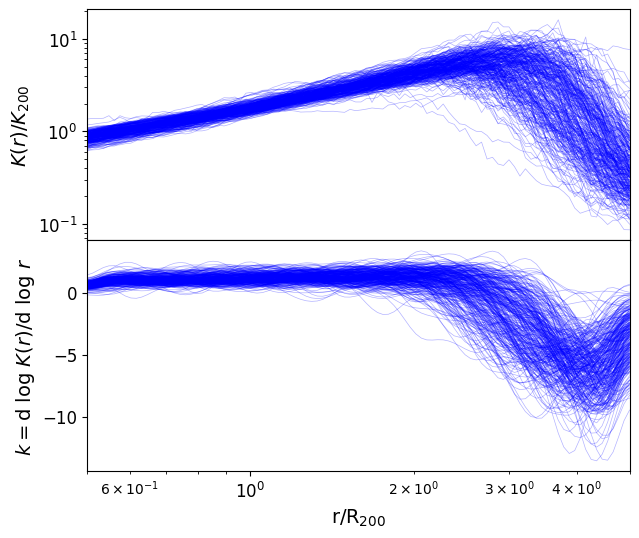

In [5]:
M200 = M200_R200[:,0]
R200 = M200_R200[:,1]
K200 = 0.5 / (200*rhonorm*0.156)**(2/3) * 4.3e-6 * M200 / R200
print(K200[:10])

# Gas entropy profile
Rsh=[]
Gas_K=[]
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in range(Gas_entropy.shape[0]):
# for i in range(10):
    ax1.plot(log_bins, Gas_entropy[i]/K200[i], color='blue',linewidth=0.5, alpha=0.3)
    # smoothed_entropy = savgol_filter(Gas_entropy[i]/K200[i], window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_entropy = gaussian_filter1d(Gas_entropy[i], sigma=2)
    log_D = np.log(smoothed_entropy)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.3) # colors[i % len(colors)]

    r_range_mask = (log_bins >= 0.55) & (log_bins <= 4.5)
    rgav_1_in_range = log_bins[r_range_mask]
    umed_av_in_range = smoothed_entropy[r_range_mask]
    
    if len(umed_av_in_range) > 0:
        max_entropy_index = np.argmax(umed_av_in_range)
        r_shock = rgav_1_in_range[max_entropy_index]

        interp_func = interp1d(log_bins, smoothed_entropy, kind='cubic')
        log_bins_dense = np.linspace(r_shock-0.2, r_shock+0.2, 500)
        smoothed_entropy_dense = interp_func(log_bins_dense)
        max_index = np.argmax(smoothed_entropy_dense)
        r_shock = log_bins_dense[max_index]

    Rsh.append(r_shock)
    Gas_K.append(smoothed_entropy/K200[i])

median_Gas_entropy = np.median(Gas_K, axis=0)
percentile16_Gas_entropy = np.percentile(Gas_K, 16, axis=0)
percentile84_Gas_entropy = np.percentile(Gas_K, 84, axis=0)
# ax1.plot(log_bins, median_Gas_entropy, color='r', linewidth=3.0, alpha=1)
# ax1.fill_between(log_bins, percentile16_Gas_entropy, percentile84_Gas_entropy, color='r', alpha=0.3)

d_log_D_all = []
for entropy in Gas_K:
    # smoothed_entropy = savgol_filter(entropy, window_length=15, polyorder=4, deriv=0, delta=0.1)
    smoothed_entropy = gaussian_filter1d(entropy, sigma=2)
    log_D = np.log(smoothed_entropy)
    d_log_D = np.gradient(log_D, log_r)
    # smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    smoothed_d_log_D = gaussian_filter1d(d_log_D, sigma=2)
    d_log_D_all.append(smoothed_d_log_D)

d_log_D_all = np.array(d_log_D_all)
median_d_log_D = np.median(d_log_D_all, axis=0)
percentile16_d_log_D = np.percentile(d_log_D_all, 16, axis=0)
percentile84_d_log_D = np.percentile(d_log_D_all, 84, axis=0)
# ax2.plot(log_bins, median_d_log_D, color='r', linestyle='-', linewidth=3.0)
# ax2.fill_between(log_bins, percentile16_d_log_D, percentile84_d_log_D, color='r', alpha=0.3)

r_range_mask = (log_bins >= 1) & (log_bins <= 5)
rgav_1_in_range = log_bins[r_range_mask]
umed_av_in_range = median_Gas_entropy[r_range_mask]
if len(umed_av_in_range) > 0:
    max_entropy_index = np.argmax(umed_av_in_range)
    r_shock1 = rgav_1_in_range[max_entropy_index]
# ax1.axvline(x=r_shock1, color='black', linestyle='--', linewidth=2)
# ax2.axvline(x=r_shock1, color='black', linestyle='--', linewidth=2)
print(r_shock1)

# restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 6))[0]
# rr = log_bins[restricted_indices]
# smoothed_d_log_D_restricted = median_d_log_D[restricted_indices]
# r_splash_index = np.argmin(smoothed_d_log_D_restricted)
# r_splash2 = rr[r_splash_index]
# ax1.axvline(x=r_splash2, color='black', linestyle=':', linewidth=2.0)
# ax2.axvline(x=r_splash2, color='black', linestyle=':', linewidth=2.0)
# ax2.axhline(y=0, color='black', linestyle='--', linewidth=2.0)
# print(r_splash2)

ax1.set_ylabel(r'$K(r)/K_{200}$', fontsize=14) #/K_{200}
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.5,5)
ax1.get_xaxis().set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel(r'${\rm r/R}_{200}$', fontsize=14)
ax2.set_ylabel(r'$k = {\rm d~log}~K(r) / {\rm d~log}~r$', fontsize=14)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlim(0.5,5)
# ax2.set_ylim(-6,3.5)
# plt.savefig("./figures/GAS_shock_radius_GadgetX.png")

Fit: Rsh = 0.57 * Rsp + 1.67
1.8391898859143172 1.424017934217901 0.7742636826811269


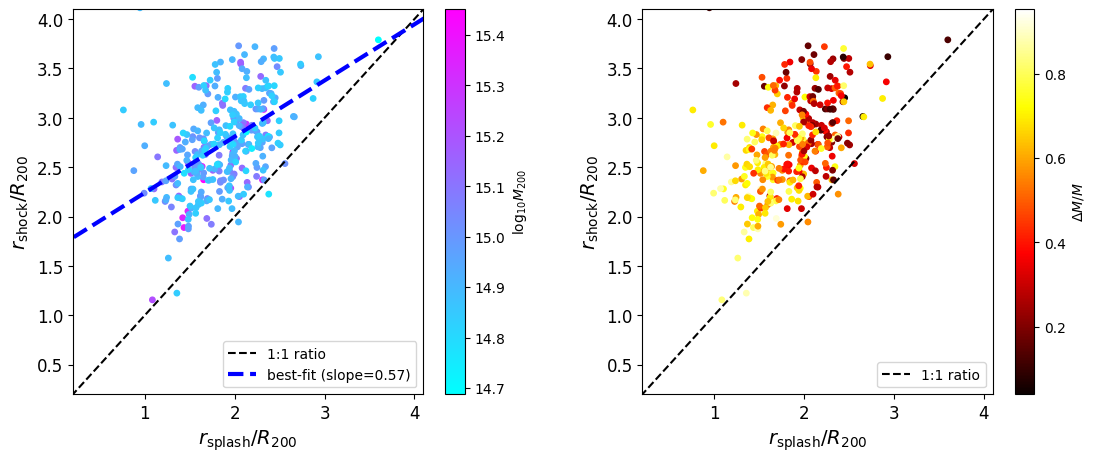

In [6]:
M200 = M200_R200[:,0]

redshifts = History[:, 0]
masses = History[:, 1:]
interp_func = interp1d(redshifts, masses, axis=0, kind='linear', fill_value="extrapolate")
mass_z0 = interp_func(0)
mass_z05 = interp_func(0.5)
accretion_rate = (mass_z0 - mass_z05) / mass_z0

fig = plt.figure(figsize=(13, 5))
plt.subplots_adjust(wspace=0.3)
ax1=fig.add_subplot(1,2,1)
norm = plt.Normalize(np.log10(M200).min(), np.log10(M200).max())
cmap = plt.cm.cool
sc1 = ax1.scatter(Rsp, Rsh, c=np.log10(M200), cmap=cmap, norm=norm, s=15)
cbar = plt.colorbar(sc1, ax=ax1)
cbar.set_label(r'log$_{10} M_{200}$')
ax1.plot([0.1, 6], [0.1, 6], color='black', linestyle='--', label='1:1 ratio')
# ax1.scatter(r_splash1, r_shock1, color='r',s=120, marker='*', label='median value')

def linear_model(x, k, b):
    return k * x + b

popt, pcov = curve_fit(linear_model, Rsp, Rsh)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）

# Rsp_range = np.linspace(min(Rsp), max(Rsp), 100)
Rsp_range = np.linspace(0, 5, 100)
Rsh_fit = linear_model(Rsp_range, k_fit, b_fit)
Rsh_fit_upper = linear_model(Rsp_range, k_fit + sigma[0], b_fit + sigma[1])
Rsh_fit_lower = linear_model(Rsp_range, k_fit - sigma[0], b_fit - sigma[1])

# plt.plot(Rsp_range, Rsh_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='b', linestyle='--', linewidth=3)
plt.plot(Rsp_range, Rsh_fit, label=f'best-fit (slope={k_fit:.2f})', color='b', linestyle='--', linewidth=3)
print(f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}')
# plt.fill_between(Rsp_range, Rsh_fit_lower, Rsh_fit_upper, color='red', alpha=0.2, label='1-Sigma Range')

# sns.kdeplot(x=Rsp, y=Rsh, cmap="viridis", shade=False, thresh=0.05, levels=4)

slope, intercept, r_value, p_value, std_err = stats.linregress(Rsp, Rsh)
Rsh_fit = slope * np.array(Rsp) + intercept
# 标准误差乘以1.96表示95%置信区间范围 (约±2 sigma)
# sigma = std_err * np.sqrt(1 / len(Rsp) + (Rsp - np.mean(Rsp))**2 / np.sum((Rsp - np.mean(Rsp))**2))
# plt.plot(Rsp, Rsh_fit, 'r', label=f'Fitted line: y = {slope:.2f}x + {intercept:.2f}')
# plt.fill_between(Rsp, Rsh_fit - sigma, Rsh_fit + sigma, color='gray', alpha=0.2, label='1 Sigma range')

plt.xlim(0.2,4.1)
plt.ylim(0.2,4.1)
plt.xlabel(r'$r_{\rm splash}/R_{200}$', fontsize=14)
plt.ylabel(r'$r_{\rm shock}/R_{200}$', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='lower right')

ax2=fig.add_subplot(1,2,2)

norm = plt.Normalize(accretion_rate.min(), accretion_rate.max())
cmap = plt.cm.hot
sc2 = ax2.scatter(Rsp, Rsh, c=accretion_rate, cmap=cmap, norm=norm, s=15)
cbar = plt.colorbar(sc2, ax=ax2)
cbar.set_label(r'$\Delta M / M$')
ax2.plot([0.1, 6], [0.1, 6], color='black', linestyle='--', label='1:1 ratio')
# ax2.scatter(r_splash1, r_shock1, color='b',s=120, marker='*', label='median value')


print(r_splash1, r_shock1, r_shock1/r_splash1)


plt.xlim(0.2,4.1)
plt.ylim(0.2,4.1)
plt.xlabel(r'$r_{\rm splash}/R_{200}$', fontsize=14)
plt.ylabel(r'$r_{\rm shock}/R_{200}$', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='lower right')
# plt.savefig("./figures/Rsplash_Rshock.png")

Fit: Rsh = -0.74 * M200 + 13.85
Fit: Rsp = -0.53 * M200 + 9.78


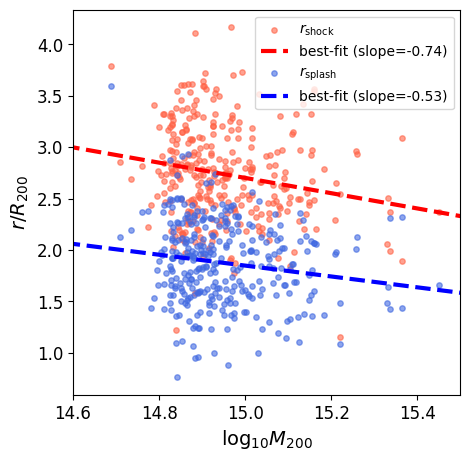

In [7]:
M200 = M200_R200[:,0]
fig = plt.figure(figsize=(5, 5))
ax1=fig.add_subplot(1,1,1)
ax1.scatter(np.log10(M200), np.array(Rsh), color='tomato',s=15, alpha=0.6, label=r'$r_{\rm shock}$')

popt, pcov = curve_fit(linear_model, np.log10(M200), Rsh)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）

# M200_range = np.linspace(min(np.log10(M200)), max(np.log10(M200)), 100)
M200_range = np.linspace(14, 16, 100)
Rsh_fit = linear_model(M200_range, k_fit, b_fit)
Rsh_fit_upper = linear_model(M200_range, k_fit + sigma[0], b_fit + sigma[1])
Rsh_fit_lower = linear_model(M200_range, k_fit - sigma[0], b_fit - sigma[1])

# plt.plot(M200_range, Rsh_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='red', linestyle='--', linewidth=2)
plt.plot(M200_range, Rsh_fit, color='red', linestyle='--', linewidth=3, label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsh = {k_fit:.2f} * M200 + {b_fit:.2f}')

ax1.scatter(np.log10(M200), np.array(Rsp), color='royalblue',s=15, alpha=0.6, label=r'$r_{\rm splash}$')

popt, pcov = curve_fit(linear_model, np.log10(M200), Rsp)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）

# M200_range = np.linspace(min(np.log10(M200)), max(np.log10(M200)), 100)
M200_range = np.linspace(14, 16, 100)
Rsp_fit = linear_model(M200_range, k_fit, b_fit)
Rsp_fit_upper = linear_model(M200_range, k_fit + sigma[0], b_fit + sigma[1])
Rsp_fit_lower = linear_model(M200_range, k_fit - sigma[0], b_fit - sigma[1])

# plt.plot(M200_range, Rsp_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='b', linestyle='--', linewidth=2)
plt.plot(M200_range, Rsp_fit, color='b', linestyle='--', linewidth=3,label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsp = {k_fit:.2f} * M200 + {b_fit:.2f}')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel(r'$r/R_{200}$', fontsize=14)
plt.xlabel(r'log$_{10} M_{200}$', fontsize=14)
plt.xlim(14.6,15.5)
# plt.ylim(0.2,4.1)
plt.legend()
# plt.savefig("./figures/Mass_radius.png")

Fit: Rsh = -1.10 * acrretion + 3.30
Fit: Rsp = -1.01 * acrretion + 2.40


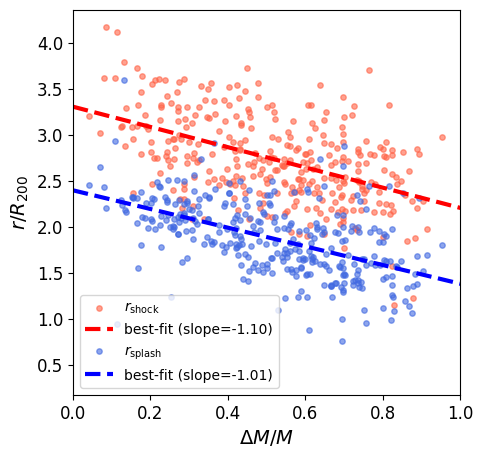

In [8]:
redshifts = History[:, 0]
masses = History[:, 1:]
interp_func = interp1d(redshifts, masses, axis=0, kind='linear', fill_value="extrapolate")
mass_z0 = interp_func(0)
mass_z05 = interp_func(0.5)
accretion_rate = (mass_z0 - mass_z05) / mass_z0

fig = plt.figure(figsize=(5, 5))
ax1=fig.add_subplot(1,1,1)
ax1.scatter(accretion_rate, np.array(Rsh), color='tomato',s=15, alpha=0.6, label=r'$r_{\rm shock}$')

popt, pcov = curve_fit(linear_model, accretion_rate, Rsh)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）

# accretion_rate_range = np.linspace(min(accretion_rate), max(accretion_rate), 100)
accretion_rate_range = np.linspace(0, 2, 100)
Rsh_fit = linear_model(accretion_rate_range, k_fit, b_fit)
Rsh_fit_upper = linear_model(accretion_rate_range, k_fit + sigma[0], b_fit + sigma[1])
Rsh_fit_lower = linear_model(accretion_rate_range, k_fit - sigma[0], b_fit - sigma[1])

# plt.plot(M200_range, Rsh_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='red', linestyle='--', linewidth=2)
plt.plot(accretion_rate_range, Rsh_fit, color='r', linestyle='--', linewidth=3,label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsh = {k_fit:.2f} * acrretion + {b_fit:.2f}')


ax1.scatter(accretion_rate, np.array(Rsp), color='royalblue',s=15, alpha=0.6, label=r'$r_{\rm splash}$')

popt, pcov = curve_fit(linear_model, accretion_rate, Rsp)
k_fit, b_fit = popt
sigma = np.sqrt(np.diag(pcov))  # 参数的标准差（1-sigma 范围）

# accretion_rate_range = np.linspace(min(accretion_rate), max(accretion_rate), 100)
accretion_rate_range = np.linspace(0, 2, 100)
Rsp_fit = linear_model(accretion_rate_range, k_fit, b_fit)
Rsp_fit_upper = linear_model(accretion_rate_range, k_fit + sigma[0], b_fit + sigma[1])
Rsp_fit_lower = linear_model(accretion_rate_range, k_fit - sigma[0], b_fit - sigma[1])

# plt.plot(M200_range, Rsp_fit, label=f'Fit: Rsh = {k_fit:.2f} * Rsp + {b_fit:.2f}', color='b', linestyle='--', linewidth=2)
plt.plot(accretion_rate_range, Rsp_fit, color='b', linestyle='--', linewidth=3,label=f'best-fit (slope={k_fit:.2f})')
print(f'Fit: Rsp = {k_fit:.2f} * acrretion + {b_fit:.2f}')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel(r'$r/R_{200}$', fontsize=14)
plt.xlabel(r'$\Delta M / M$', fontsize=14)
plt.xlim(0,1)
plt.legend()
# plt.savefig("./figures/Accretion_radius.png")